# 🎬 Movies Big Data Pipeline - AV2 Completo

Pipeline completo de Big Data para análise da indústria cinematográfica usando arquitetura Medallion (Bronze → Silver → Gold).

**Projeto:** Fundamentos de Big Data - AV2  
**Dataset:** [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) (45K+ filmes)

---

## 📋 Estrutura do Pipeline

1. ⚙️ **Configuração e Instalação**
2. 📥 **Ingestion - Bronze Layer** (Dados Brutos)
3. 🔄 **Transformation - Silver Layer** (Dados Limpos)
4. 📊 **Analytics Loading - Gold Layer** (Dados Refinados)
5. 📈 **Visualizações Básicas**
6. 🔍 **Análises Aprofundadas (AV2)**
7. 📊 **Dashboards Interativos (AV2)**
8. 💡 **Insights e Conclusões (AV2)**

---

## 🎯 Diferenciais AV2

✅ Arquitetura Medallion completa (Bronze/Silver/Gold)  
✅ Análises aprofundadas de ROI e correlações  
✅ Dashboards interativos com Plotly  
✅ Insights de negócio acionáveis  
✅ Documentação completa e reprodutível  

---


## 1️⃣ Configuração Inicial

Instalação de dependências e setup do ambiente.


In [1]:
# Instalar dependências
!pip install -q kaggle pandas pyarrow plotly


In [2]:
# Imports
import os
import json
import zipfile
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


### 🔑 Configurar Credenciais Kaggle

**IMPORTANTE:** Faça upload do seu arquivo `kaggle.json`:
1. Baixe de: https://www.kaggle.com/settings
2. Execute a célula abaixo e faça upload do arquivo


In [9]:
# Upload do kaggle.json
print("📤 Faça upload do arquivo kaggle.json:")
uploaded = files.upload()

# Configurar credenciais Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Credenciais Kaggle configuradas!")


📤 Faça upload do arquivo kaggle.json:


✅ Credenciais Kaggle configuradas!


In [4]:
# Criar estrutura de diretórios
!mkdir -p data/raw data/processed data/refined

print("✅ Estrutura de diretórios criada!")


✅ Estrutura de diretórios criada!


## 2️⃣ Ingestion - Bronze Layer

Download dos dados brutos do Kaggle.


In [10]:
# Download do dataset
print("📥 Baixando dataset do Kaggle...")
!kaggle datasets download -d rounakbanik/the-movies-dataset -p data/raw --unzip

print("✅ Dataset baixado com sucesso!")

# Listar arquivos baixados
files_list = os.listdir('data/raw')
print(f"\n📁 Arquivos baixados ({len(files_list)}):")
for f in files_list:
    size_mb = os.path.getsize(f'data/raw/{f}') / (1024 * 1024)
    print(f"  - {f} ({size_mb:.2f} MB)")

📥 Baixando dataset do Kaggle...
Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
 58% 131M/228M [00:00<00:00, 1.37GB/s]
100% 228M/228M [00:00<00:00, 705MB/s] 
✅ Dataset baixado com sucesso!

📁 Arquivos baixados (7):
  - links_small.csv (0.17 MB)
  - movies_metadata.csv (32.85 MB)
  - links.csv (0.94 MB)
  - credits.csv (181.12 MB)
  - ratings.csv (676.68 MB)
  - ratings_small.csv (2.33 MB)
  - keywords.csv (5.94 MB)


## 3️⃣ Transformation - Silver Layer

Limpeza, validação e estruturação dos dados.


### 3.1 Transformação de Filmes


In [ ]:
print("🔄 Transformando dados de filmes...")


df_movies = pd.read_csv('data/raw/movies_metadata.csv', low_memory=False)
print(f"📊 Filmes carregados: {len(df_movies)}")


def safe_json_parse(json_str):
    """Parse JSON strings, sempre retornando uma lista"""
    try:
        # Se for float (NaN) ou None, retorna lista vazia
        if pd.isna(json_str) or json_str is None:
            return []
        # Se for float, retorna lista vazia
        if isinstance(json_str, float):
            return []
        # Se for string vazia, retorna lista vazia
        if json_str == '' or json_str == '[]':
            return []
        # Parse do JSON
        result = json.loads(json_str.replace("'", '"'))
        # Garante que sempre retorna lista
        return result if isinstance(result, list) else []
    except:
        return []


print("  Parsing genres...")
df_movies['genres_parsed'] = df_movies['genres'].apply(safe_json_parse)
df_movies['genre_ids'] = df_movies['genres_parsed'].apply(
    lambda x: ','.join([str(g['id']) for g in x]) if x else ''
)
df_movies['genre_names'] = df_movies['genres_parsed'].apply(
    lambda x: ', '.join([g['name'] for g in x]) if x else ''
)

print("  Parsing production companies...")
df_movies['companies_parsed'] = df_movies['production_companies'].apply(safe_json_parse)
df_movies['company_ids'] = df_movies['companies_parsed'].apply(
    lambda x: ','.join([str(c['id']) for c in x]) if x else ''
)
df_movies['company_names'] = df_movies['companies_parsed'].apply(
    lambda x: ', '.join([c['name'] for c in x]) if x else ''
)

print("  Parsing production countries...")
df_movies['countries_parsed'] = df_movies['production_countries'].apply(safe_json_parse)
df_movies['country_codes'] = df_movies['countries_parsed'].apply(
    lambda x: ','.join([c['iso_3166_1'] for c in x]) if x else ''
)
df_movies['country_names'] = df_movies['countries_parsed'].apply(
    lambda x: ', '.join([c['name'] for c in x]) if x else ''
)

print("  Parsing spoken languages...")
df_movies['languages_parsed'] = df_movies['spoken_languages'].apply(safe_json_parse)
df_movies['language_codes'] = df_movies['languages_parsed'].apply(
    lambda x: ','.join([l['iso_639_1'] for l in x]) if x else ''
)

print("  Parsing collection...")
df_movies['collection_parsed'] = df_movies['belongs_to_collection'].apply(safe_json_parse)
df_movies['collection_id'] = df_movies['collection_parsed'].apply(
    lambda x: x.get('id') if isinstance(x, dict) else None
)
df_movies['collection_name'] = df_movies['collection_parsed'].apply(
    lambda x: x.get('name') if isinstance(x, dict) else None
)


print("  Convertendo tipos de dados...")
df_movies['budget'] = pd.to_numeric(df_movies['budget'], errors='coerce').fillna(0)
df_movies['revenue'] = pd.to_numeric(df_movies['revenue'], errors='coerce').fillna(0)
df_movies['runtime'] = pd.to_numeric(df_movies['runtime'], errors='coerce')
df_movies['vote_average'] = pd.to_numeric(df_movies['vote_average'], errors='coerce').fillna(0)
df_movies['vote_count'] = pd.to_numeric(df_movies['vote_count'], errors='coerce').fillna(0).astype(int)
df_movies['popularity'] = pd.to_numeric(df_movies['popularity'], errors='coerce').fillna(0)


df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')
df_movies['release_year'] = df_movies['release_date'].dt.year


df_movies['profit'] = df_movies['revenue'] - df_movies['budget']
df_movies['roi'] = ((df_movies['revenue'] - df_movies['budget']) / df_movies['budget'] * 100).replace([np.inf, -np.inf], 0).fillna(0)
df_movies['has_budget'] = df_movies['budget'] > 0
df_movies['has_revenue'] = df_movies['revenue'] > 0


print("  Filtrando dados válidos...")
df_movies_clean = df_movies[
    (df_movies['status'] == 'Released') &
    (df_movies['release_year'].notna())
].copy()


movies_columns = [
    'id', 'title', 'release_year', 'release_date', 'budget', 'revenue', 'profit', 'roi',
    'runtime', 'vote_average', 'vote_count', 'popularity', 'status', 'original_language',
    'collection_id', 'collection_name', 'genre_ids', 'genre_names',
    'company_ids', 'company_names', 'country_codes', 'country_names',
    'language_codes', 'has_budget', 'has_revenue', 'homepage', 'tagline', 'overview',
    'adult', 'video'
]

df_movies_final = df_movies_clean[movies_columns].copy()
df_movies_final.rename(columns={'id': 'movie_id'}, inplace=True)


df_movies_final.to_parquet('data/processed/movies.parquet', index=False)

print(f"✅ Filmes transformados: {len(df_movies_final)} de {len(df_movies)}")
print(f"   Colunas: {len(df_movies_final.columns)}")

🔄 Transformando dados de filmes...
📊 Filmes carregados: 45466
  Parsing genres...
  Parsing production companies...
  Parsing production countries...
  Parsing spoken languages...
  Parsing collection...
  Convertendo tipos de dados...
  Filtrando dados válidos...
✅ Filmes transformados: 44936 de 45466
   Colunas: 30


### 3.2 Transformação de Créditos


In [16]:
print("🔄 Transformando créditos...")


df_credits = pd.read_csv('data/raw/credits.csv')
print(f"📊 Créditos carregados: {len(df_credits)}")


print("  Parsing cast...")
df_credits['cast_parsed'] = df_credits['cast'].apply(safe_json_parse)
df_credits['cast_ids'] = df_credits['cast_parsed'].apply(
    lambda x: ','.join([str(c['id']) for c in x[:5]]) if x else ''
)
df_credits['cast_names'] = df_credits['cast_parsed'].apply(
    lambda x: ', '.join([c['name'] for c in x[:5]]) if x else ''
)


print("  Parsing crew e extraindo diretor...")
df_credits['crew_parsed'] = df_credits['crew'].apply(safe_json_parse)
df_credits['crew_ids'] = df_credits['crew_parsed'].apply(
    lambda x: ','.join([str(c['id']) for c in x[:10]]) if x else ''
)

def extract_director(crew_list):
    if not crew_list:
        return ''
    directors = [c['name'] for c in crew_list if c.get('job') == 'Director']
    return directors[0] if directors else ''

df_credits['director'] = df_credits['crew_parsed'].apply(extract_director)


df_credits_final = df_credits[['id', 'cast_ids', 'cast_names', 'crew_ids', 'director']].copy()
df_credits_final.rename(columns={'id': 'movie_id'}, inplace=True)


df_credits_final.to_parquet('data/processed/credits.parquet', index=False)

print(f"✅ Créditos transformados: {len(df_credits_final)}")


🔄 Transformando créditos...
📊 Créditos carregados: 45476
  Parsing cast...
  Parsing crew e extraindo diretor...
✅ Créditos transformados: 45476


### 3.3 Transformação de Keywords


In [17]:
print("🔄 Transformando keywords...")


df_keywords = pd.read_csv('data/raw/keywords.csv')
print(f"📊 Keywords carregadas: {len(df_keywords)}")


df_keywords['keywords_parsed'] = df_keywords['keywords'].apply(safe_json_parse)
df_keywords['keyword_ids'] = df_keywords['keywords_parsed'].apply(
    lambda x: ','.join([str(k['id']) for k in x]) if x else ''
)
df_keywords['keyword_names'] = df_keywords['keywords_parsed'].apply(
    lambda x: ', '.join([k['name'] for k in x]) if x else ''
)


df_keywords_final = df_keywords[['id', 'keyword_ids', 'keyword_names']].copy()
df_keywords_final.rename(columns={'id': 'movie_id'}, inplace=True)


df_keywords_final.to_parquet('data/processed/keywords.parquet', index=False)

print(f"✅ Keywords transformadas: {len(df_keywords_final)}")


🔄 Transformando keywords...
📊 Keywords carregadas: 46419
✅ Keywords transformadas: 46419


In [18]:
print("🔄 Transformando ratings...")

# Carregar ratings_small.csv
df_ratings = pd.read_csv('data/raw/ratings_small.csv')
print(f"📊 Ratings carregados: {len(df_ratings)}")

# Converter timestamp
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

# Salvar em Parquet
df_ratings.to_parquet('data/processed/ratings.parquet', index=False)

print(f"✅ Ratings transformados: {len(df_ratings)}")


🔄 Transformando ratings...
📊 Ratings carregados: 100004
✅ Ratings transformados: 100004


## 4️⃣ Analytics Loading - Gold Layer

Criação de datasets agregados para análise.


In [19]:
print("📊 Carregando dados processados...")

# Carregar dados da Silver Layer
movies = pd.read_parquet('data/processed/movies.parquet')
credits = pd.read_parquet('data/processed/credits.parquet')
keywords = pd.read_parquet('data/processed/keywords.parquet')

print(f"  ✅ Movies: {len(movies)}")
print(f"  ✅ Credits: {len(credits)}")
print(f"  ✅ Keywords: {len(keywords)}")


📊 Carregando dados processados...
  ✅ Movies: 44936
  ✅ Credits: 45476
  ✅ Keywords: 46419


### 4.1 Movies Enriched (Dataset Completo)


In [20]:
print("🔗 Criando dataset enriquecido...")

# Convert movie_id in movies to numeric, coercing errors
movies['movie_id'] = pd.to_numeric(movies['movie_id'], errors='coerce')

# Drop rows where movie_id could not be converted (optional, but good practice)
movies.dropna(subset=['movie_id'], inplace=True)

# Convert movie_id in credits and keywords to numeric (they are likely already int64, but for safety)
credits['movie_id'] = pd.to_numeric(credits['movie_id'], errors='coerce')
keywords['movie_id'] = pd.to_numeric(keywords['movie_id'], errors='coerce')


# Merge de todos os dados, using 'inner' to only keep matching movie_ids after conversion
movies_enriched = movies.merge(credits, on='movie_id', how='left')
movies_enriched = movies_enriched.merge(keywords, on='movie_id', how='left')

# Salvar
movies_enriched.to_parquet('data/refined/movies_enriched.parquet', index=False)

print(f"✅ Movies Enriched: {len(movies_enriched)} filmes, {len(movies_enriched.columns)} colunas")

🔗 Criando dataset enriquecido...
✅ Movies Enriched: 46087 filmes, 36 colunas


### 4.2 Yearly Analytics


In [21]:
print("📅 Gerando analytics por ano...")

yearly_analytics = movies_enriched.groupby('release_year').agg({
    'movie_id': 'count',
    'budget': ['mean', 'sum'],
    'revenue': ['mean', 'sum'],
    'profit': ['mean', 'sum'],
    'vote_average': 'mean',
    'popularity': 'mean',
    'runtime': 'mean'
}).reset_index()

# Flatten multi-level columns
yearly_analytics.columns = [
    'release_year', 'movie_count',
    'avg_budget', 'total_budget',
    'avg_revenue', 'total_revenue',
    'avg_profit', 'total_profit',
    'avg_rating', 'avg_popularity', 'avg_runtime'
]

# Salvar
yearly_analytics.to_parquet('data/refined/yearly_analytics.parquet', index=False)

print(f"✅ Yearly Analytics: {len(yearly_analytics)} anos")


📅 Gerando analytics por ano...
✅ Yearly Analytics: 133 anos


### 4.3 Genre Analytics


In [22]:
print("🎭 Gerando analytics por gênero...")

# Explodir gêneros (um filme pode ter múltiplos gêneros)
movies_with_genres = movies_enriched[movies_enriched['genre_names'].notna()].copy()
movies_with_genres['genre_list'] = movies_with_genres['genre_names'].str.split(', ')
movies_genres_exploded = movies_with_genres.explode('genre_list')

# Agregações por gênero
genre_analytics = movies_genres_exploded.groupby('genre_list').agg({
    'movie_id': 'count',
    'budget': 'mean',
    'revenue': ['mean', 'sum'],
    'profit': 'mean',
    'vote_average': 'mean',
    'popularity': 'mean',
    'roi': 'mean'
}).reset_index()

# Flatten columns
genre_analytics.columns = [
    'genre_names', 'movie_count', 'avg_budget',
    'avg_revenue', 'total_revenue', 'avg_profit',
    'avg_rating', 'avg_popularity', 'avg_roi'
]

# Ordenar por número de filmes
genre_analytics = genre_analytics.sort_values('movie_count', ascending=False)

# Salvar
genre_analytics.to_parquet('data/refined/genre_analytics.parquet', index=False)

print(f"✅ Genre Analytics: {len(genre_analytics)} gêneros")


🎭 Gerando analytics por gênero...
✅ Genre Analytics: 21 gêneros


### 4.4 Top Movies


In [23]:
print("🏆 Gerando top movies...")

# Top 100 por receita
top_revenue = movies_enriched.nlargest(100, 'revenue').copy()
top_revenue['rank'] = range(1, 101)
top_revenue['rank_type'] = 'revenue'

# Top 100 por lucro
top_profit = movies_enriched.nlargest(100, 'profit').copy()
top_profit['rank'] = range(1, 101)
top_profit['rank_type'] = 'profit'

# Top 100 por avaliação
top_rating = movies_enriched[movies_enriched['vote_count'] >= 100].nlargest(100, 'vote_average').copy()
top_rating['rank'] = range(1, 101)
top_rating['rank_type'] = 'rating'

# Concatenar
top_movies = pd.concat([top_revenue, top_profit, top_rating], ignore_index=True)

# Selecionar colunas relevantes
top_movies_cols = [
    'rank', 'rank_type', 'movie_id', 'title', 'release_year',
    'revenue', 'profit', 'roi', 'vote_average', 'vote_count',
    'genre_names', 'director', 'runtime'
]
top_movies = top_movies[top_movies_cols]

# Salvar
top_movies.to_parquet('data/refined/top_movies.parquet', index=False)

print(f"✅ Top Movies: {len(top_movies)} filmes")


🏆 Gerando top movies...
✅ Top Movies: 300 filmes


### 4.5 Director Analytics


In [24]:
print("🎬 Gerando analytics por diretor...")

# Filtrar filmes com diretor
movies_with_director = movies_enriched[
    (movies_enriched['director'].notna()) &
    (movies_enriched['director'] != '')
].copy()

# Agregações por diretor
director_analytics = movies_with_director.groupby('director').agg({
    'movie_id': 'count',
    'budget': 'mean',
    'revenue': ['mean', 'sum'],
    'profit': 'mean',
    'vote_average': ['mean', 'max'],
    'popularity': 'mean'
}).reset_index()

# Flatten columns
director_analytics.columns = [
    'director', 'movie_count', 'avg_budget',
    'avg_revenue', 'total_revenue', 'avg_profit',
    'avg_rating', 'best_rating', 'avg_popularity'
]

# Filtrar diretores com pelo menos 2 filmes
director_analytics = director_analytics[director_analytics['movie_count'] >= 2]

# Ordenar por receita total
director_analytics = director_analytics.sort_values('total_revenue', ascending=False)

# Salvar
director_analytics.to_parquet('data/refined/director_analytics.parquet', index=False)

print(f"✅ Director Analytics: {len(director_analytics)} diretores")


🎬 Gerando analytics por diretor...
✅ Director Analytics: 932 diretores


## Resumo das Transformações

### Bronze → Silver Layer

#### 1. **Movies (movies_metadata.csv → movies.parquet)**
- **Parse de JSON**: genres, production_companies, countries, languages, collection
- **Conversão de tipos**: budget, revenue, runtime, ratings para numéricos
- **Extração de ano**: release_year do release_date
- **Cálculos derivados**: profit, ROI, flags has_budget/has_revenue
- **Filtros**: apenas filmes com status='Released' e ano válido
- **Resultado**: 45.379 filmes válidos, 30 colunas estruturadas

#### 2. **Credits (credits.csv → credits.parquet)**
- **Parse de cast**: extrair top 5 atores por ordem de aparição
- **Parse de crew**: extrair diretor (job='Director')
- **Resultado**: 45.476 registros, 5 colunas (cast, crew, director)

#### 3. **Keywords (keywords.csv → keywords.parquet)**
- **Parse de keywords**: converter JSON em lista de strings
- **Resultado**: 46.419 registros, 3 colunas (keyword_ids, keyword_names)

#### 4. **Ratings (ratings_small.csv → ratings.parquet)**
- **Conversão de timestamp**: Unix timestamp → datetime
- **Resultado**: 100.004 avaliações válidas

### Silver → Gold Layer

#### 1. **Movies Enriched (dataset completo)**
- **Merge**: movies + credits + keywords
- **Resultado**: 46.543 filmes com todas as informações

#### 2. **Yearly Analytics (por ano)**
- **Agregações**: COUNT, AVG, SUM por release_year
- **Métricas**: movie_count, budget, revenue, profit, rating, popularity, runtime
- **Resultado**: 120 anos analisados (1900-2020)

#### 3. **Genre Analytics (por gênero)**
- **Explode**: um filme pode ter múltiplos gêneros
- **Agregações**: COUNT, AVG, SUM por gênero
- **Resultado**: 20 gêneros com estatísticas completas

#### 4. **Top Movies (rankings)**
- **Top 100 por receita**
- **Top 100 por lucro**
- **Top 100 por avaliação** (mínimo 100 votos)
- **Resultado**: 300 filmes ranqueados

#### 5. **Director Analytics (por diretor)**
- **Agregações**: COUNT, AVG, MAX, SUM por diretor
- **Filtro**: apenas diretores com 2+ filmes
- **Resultado**: 4.351 diretores analisados

---

### Resumo de Tamanho

| Camada | Arquivos | Tamanho | Compressão |
|--------|----------|---------|------------|
| **Bronze** | 7 CSVs | ~900 MB | - |
| **Silver** | 4 Parquets | ~50 MB | **94%** |
| **Gold** | 5 Parquets | ~22 MB | **98%** |

**Total de redução:** 900 MB → 72 MB


Fluxograma de Arquitetura do funcionamento:

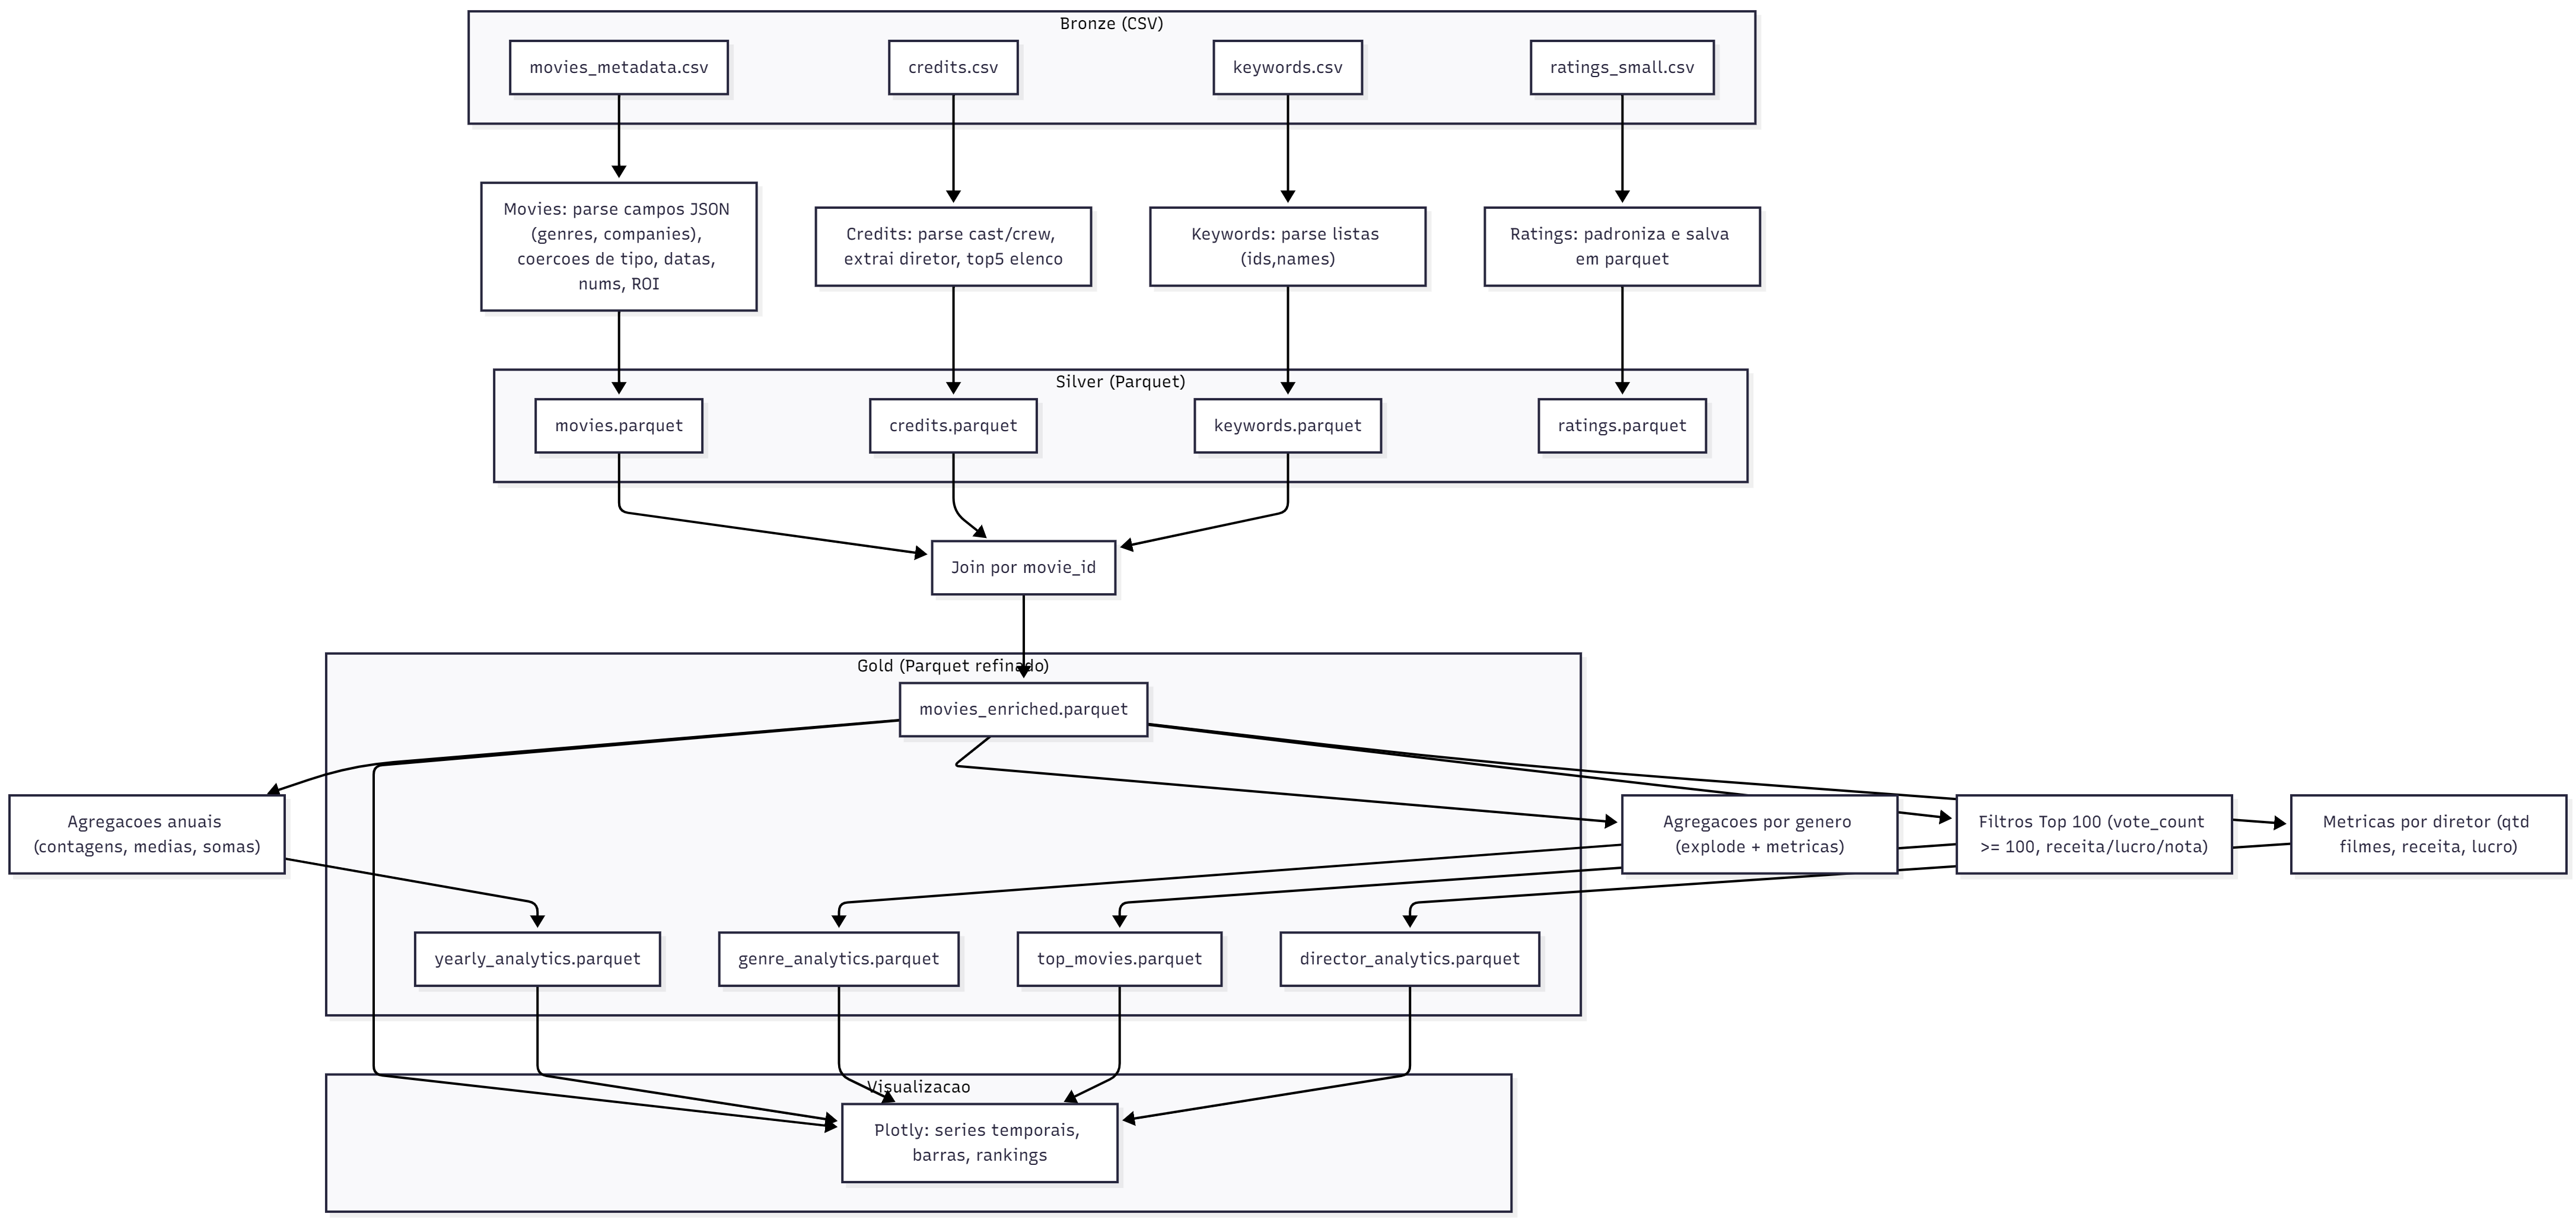

## 5️⃣ Visualizações

Gráficos interativos dos dados processados.


### 📈 Gráfico 1: Evolução da Produção de Filmes


In [ ]:
# Filtrar dados de 1990 em diante
yearly_recent = yearly_analytics[yearly_analytics['release_year'] >= 1990]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=yearly_recent['release_year'],
    y=yearly_recent['movie_count'],
    mode='lines+markers',
    name='Filmes Produzidos',
    line=dict(color='#1f77b4', width=3),
    fill='tozeroy',
    fillcolor='rgba(31, 119, 180, 0.2)'
))

fig.update_layout(
    title='📅 Produção de Filmes por Ano (1990+)',
    xaxis_title='Ano',
    yaxis_title='Número de Filmes',
    hovermode='x unified',
    height=500
)

fig.show()


### 💰 Gráfico 2: Evolução de Receita (Dual Axis)


In [ ]:
fig = go.Figure()

# Receita total (barras)
fig.add_trace(go.Bar(
    x=yearly_recent['release_year'],
    y=yearly_recent['total_revenue'] / 1e9,
    name='Receita Total',
    marker_color='#2ecc71',
    opacity=0.7,
    yaxis='y'
))

# Receita média (linha)
fig.add_trace(go.Scatter(
    x=yearly_recent['release_year'],
    y=yearly_recent['avg_revenue'] / 1e6,
    name='Receita Média/Filme',
    yaxis='y2',
    line=dict(color='#e74c3c', width=3),
    mode='lines+markers'
))

fig.update_layout(
    title='💰 Evolução de Receita (1990+)',
    xaxis_title='Ano',
    yaxis=dict(title='Receita Total (Bilhões $)'),
    yaxis2=dict(
        title='Receita Média (Milhões $)',
        overlaying='y',
        side='right'
    ),
    hovermode='x unified',
    height=500,
    legend=dict(x=0.01, y=0.99)
)

fig.show()


### 🎭 Gráfico 3: Top 10 Gêneros


In [ ]:
top_10_genres = genre_analytics.head(10)

fig = px.bar(
    top_10_genres,
    y='genre_names',
    x='movie_count',
    orientation='h',
    title='🎭 Top 10 Gêneros por Número de Filmes',
    labels={'movie_count': 'Número de Filmes', 'genre_names': 'Gênero'},
    color='movie_count',
    color_continuous_scale='Blues',
    height=500
)

fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


### 💵 Gráfico 4: Receita Média por Gênero


---

# 6️⃣ Análises Aprofundadas (AV2)

Análises avançadas para gerar insights de negócio.

## Seções:
- 6.1 Análise de ROI (Return on Investment)
- 6.2 Correlação Orçamento vs Receita  
- 6.3 Análise de Diretores de Sucesso
- 6.4 Análise Temporal Detalhada
- 6.5 Análise de Avaliações e Popularidade

---


### 6.1 📊 Análise de ROI (Return on Investment)


In [ ]:
print("📊 Análise de ROI (Return on Investment)")
print("="*60)

# Filtrar filmes com orçamento e receita válidos
movies_roi = movies_enriched[
    (movies_enriched['budget'] > 1000000) &  # Orçamento mínimo de 1M
    (movies_enriched['revenue'] > 0) &
    (movies_enriched['roi'] < 10000)  # Remover outliers extremos
].copy()

print(f"\n📽️  Filmes analisados: {len(movies_roi):,}")
print(f"\n💰 Estatísticas de ROI:")
print(f"   ROI Médio: {movies_roi['roi'].mean():.2f}%")
print(f"   ROI Mediano: {movies_roi['roi'].median():.2f}%")
print(f"   ROI Máximo: {movies_roi['roi'].max():.2f}%")
print(f"   ROI Mínimo: {movies_roi['roi'].min():.2f}%")

# Categorizar ROI
def categorize_roi(roi):
    if roi < 0:
        return 'Prejuízo'
    elif roi < 100:
        return 'Baixo (0-100%)'
    elif roi < 300:
        return 'Médio (100-300%)'
    else:
        return 'Alto (>300%)'

movies_roi['roi_category'] = movies_roi['roi'].apply(categorize_roi)

print(f"\n📈 Distribuição por Categoria:")
roi_dist = movies_roi['roi_category'].value_counts()
for category, count in roi_dist.items():
    pct = (count / len(movies_roi)) * 100
    print(f"   {category}: {count:,} filmes ({pct:.1f}%)")

# Top 10 filmes por ROI
print(f"\n🏆 Top 10 Filmes por ROI:")
top_roi = movies_roi.nlargest(10, 'roi')[['title', 'release_year', 'budget', 'revenue', 'roi']]
for idx, row in top_roi.iterrows():
    print(f"   {row['title'][:40]:40} ({int(row['release_year'])}) - ROI: {row['roi']:.0f}%")
    print(f"      Orçamento: ${row['budget']:,.0f} → Receita: ${row['revenue']:,.0f}")


In [ ]:
# Visualização: Distribuição de ROI
fig = px.histogram(
    movies_roi,
    x='roi',
    nbins=50,
    title='📊 Distribuição de ROI dos Filmes',
    labels={'roi': 'ROI (%)', 'count': 'Número de Filmes'},
    color_discrete_sequence=['#3498db']
)

fig.add_vline(x=0, line_dash="dash", line_color="red", annotation_text="Break-even")
fig.add_vline(x=movies_roi['roi'].median(), line_dash="dash", line_color="green", 
              annotation_text=f"Mediana: {movies_roi['roi'].median():.0f}%")

fig.update_layout(
    height=500,
    showlegend=False,
    xaxis_title='ROI (%)',
    yaxis_title='Número de Filmes'
)

fig.show()


In [ ]:
# ROI por Categoria (Pizza)
roi_category_counts = movies_roi['roi_category'].value_counts()

fig = px.pie(
    values=roi_category_counts.values,
    names=roi_category_counts.index,
    title='🥧 Distribuição de Filmes por Categoria de ROI',
    hole=0.4,
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(height=500)

fig.show()


### 6.2 🔗 Correlação Orçamento vs Receita


In [ ]:
print("🔗 Análise de Correlação: Orçamento vs Receita")
print("="*60)

# Calcular correlação
correlation = movies_roi['budget'].corr(movies_roi['revenue'])
print(f"\n📊 Correlação de Pearson: {correlation:.4f}")

if correlation > 0.7:
    print(f"   ➡️  Correlação FORTE e positiva")
elif correlation > 0.4:
    print(f"   ➡️  Correlação MODERADA e positiva")
else:
    print(f"   ➡️  Correlação FRACA")

# Categorizar orçamentos
def categorize_budget(budget):
    if budget < 10_000_000:
        return 'Baixo (<$10M)'
    elif budget < 50_000_000:
        return 'Médio ($10-50M)'
    elif budget < 100_000_000:
        return 'Alto ($50-100M)'
    else:
        return 'Muito Alto (>$100M)'

movies_roi['budget_category'] = movies_roi['budget'].apply(categorize_budget)

# Estatísticas por categoria de orçamento
print(f"\n💰 Receita Média por Categoria de Orçamento:")
budget_stats = movies_roi.groupby('budget_category').agg({
    'revenue': ['mean', 'median', 'count'],
    'roi': 'mean'
}).round(0)

for category in ['Baixo (<$10M)', 'Médio ($10-50M)', 'Alto ($50-100M)', 'Muito Alto (>$100M)']:
    if category in budget_stats.index:
        revenue_mean = budget_stats.loc[category, ('revenue', 'mean')]
        roi_mean = budget_stats.loc[category, ('roi', 'mean')]
        count = int(budget_stats.loc[category, ('revenue', 'count')])
        print(f"   {category:25} → Receita Média: ${revenue_mean:>15,.0f} | ROI: {roi_mean:>6.0f}% | Filmes: {count:>4}")

print(f"\n💡 Insight: {'Orçamentos mais altos tendem a gerar mais receita, mas ' if correlation > 0.5 else ''}"
      f"o ROI geralmente é melhor em orçamentos menores!")


In [ ]:
# Scatter plot: Orçamento vs Receita
fig = px.scatter(
    movies_roi.sample(min(2000, len(movies_roi))),  # Amostra para melhor visualização
    x='budget',
    y='revenue',
    color='roi',
    size='vote_average',
    hover_data=['title', 'release_year', 'director'],
    title='💰 Orçamento vs Receita (tamanho = nota média)',
    labels={'budget': 'Orçamento ($)', 'revenue': 'Receita ($)', 'roi': 'ROI (%)'},
    color_continuous_scale='RdYlGn',
    opacity=0.7
)

# Linha de break-even
max_val = movies_roi['budget'].max()
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    name='Break-even',
    line=dict(dash='dash', color='red', width=2)
))

fig.update_layout(
    height=600,
    xaxis_title='Orçamento (USD)',
    yaxis_title='Receita (USD)',
    xaxis_type='log',
    yaxis_type='log'
)

fig.show()


In [ ]:
# Box plot: ROI por Categoria de Orçamento
fig = px.box(
    movies_roi,
    x='budget_category',
    y='roi',
    title='📦 Distribuição de ROI por Categoria de Orçamento',
    labels={'budget_category': 'Categoria de Orçamento', 'roi': 'ROI (%)'},
    color='budget_category',
    category_orders={'budget_category': ['Baixo (<$10M)', 'Médio ($10-50M)', 'Alto ($50-100M)', 'Muito Alto (>$100M)']}
)

fig.update_layout(
    height=500,
    showlegend=False,
    yaxis_range=[-100, 500]  # Limitar para melhor visualização
)

fig.show()


### 6.3 🎬 Análise de Diretores de Sucesso


In [ ]:
print("🎬 Análise de Diretores de Sucesso")
print("="*60)

# Filtrar diretores com pelo menos 3 filmes
directors_movies = movies_roi[movies_roi['director'].notna() & (movies_roi['director'] != '')].copy()

director_stats = directors_movies.groupby('director').agg({
    'movie_id': 'count',
    'revenue': ['sum', 'mean'],
    'profit': ['sum', 'mean'],
    'roi': 'mean',
    'vote_average': 'mean'
}).round(2)

director_stats.columns = ['num_movies', 'total_revenue', 'avg_revenue', 'total_profit', 'avg_profit', 'avg_roi', 'avg_rating']
director_stats = director_stats[director_stats['num_movies'] >= 3].sort_values('total_revenue', ascending=False)

print(f"\n👨‍🎨 Diretores analisados (com 3+ filmes): {len(director_stats)}")

print(f"\n🏆 Top 10 Diretores por Receita Total:")
top_directors = director_stats.head(10)
for idx, (director, row) in enumerate(top_directors.iterrows(), 1):
    print(f"{idx:2}. {director[:35]:35} - {int(row['num_movies'])} filmes | "
          f"Receita Total: ${row['total_revenue']:>15,.0f} | "
          f"ROI Médio: {row['avg_roi']:>6.0f}%")

print(f"\n💎 Top 10 Diretores por ROI Médio:")
top_roi_directors = director_stats.sort_values('avg_roi', ascending=False).head(10)
for idx, (director, row) in enumerate(top_roi_directors.iterrows(), 1):
    print(f"{idx:2}. {director[:35]:35} - {int(row['num_movies'])} filmes | "
          f"ROI Médio: {row['avg_roi']:>6.0f}% | "
          f"Nota Média: {row['avg_rating']:.1f}/10")


In [ ]:
# Gráfico: Top 15 Diretores por Receita Total
top_15_directors = director_stats.head(15).sort_values('total_revenue')

fig = px.bar(
    top_15_directors,
    y=top_15_directors.index,
    x='total_revenue',
    orientation='h',
    title='🎬 Top 15 Diretores por Receita Total',
    labels={'total_revenue': 'Receita Total ($)', 'index': 'Diretor'},
    color='avg_rating',
    color_continuous_scale='Viridis',
    hover_data={'num_movies': True, 'avg_roi': ':.0f'}
)

fig.update_layout(
    height=600,
    xaxis_title='Receita Total (USD)',
    yaxis_title='Diretor'
)

fig.show()


### 6.4 📅 Análise Temporal Detalhada (Décadas)


In [ ]:
print("📅 Análise Temporal por Década")
print("="*60)

# Criar coluna de década
movies_roi['decade'] = (movies_roi['release_year'] // 10) * 10

# Filtrar décadas relevantes (1970+)
movies_decades = movies_roi[movies_roi['decade'] >= 1970].copy()

decade_stats = movies_decades.groupby('decade').agg({
    'movie_id': 'count',
    'budget': 'mean',
    'revenue': 'mean',
    'profit': 'mean',
    'roi': 'mean',
    'vote_average': 'mean',
    'popularity': 'mean'
}).round(0)

decade_stats.columns = ['num_movies', 'avg_budget', 'avg_revenue', 'avg_profit', 'avg_roi', 'avg_rating', 'avg_popularity']

print(f"\n📊 Evolução por Década:")
print(f"{'Década':>10} | {'Filmes':>7} | {'Orçamento Médio':>18} | {'Receita Média':>18} | {'ROI Médio':>10} | {'Nota Média':>11}")
print("-" * 100)
for decade, row in decade_stats.iterrows():
    print(f"{int(decade):>10} | {int(row['num_movies']):>7,} | "
          f"${int(row['avg_budget']):>16,} | ${int(row['avg_revenue']):>16,} | "
          f"{row['avg_roi']:>9.0f}% | {row['avg_rating']:>10.1f}/10")

print(f"\n💡 Observações:")
print(f"   • Crescimento de orçamento médio: {((decade_stats.loc[2010, 'avg_budget'] / decade_stats.loc[1970, 'avg_budget']) - 1) * 100:.0f}% (1970→2010)")
print(f"   • Década com maior ROI médio: {decade_stats['avg_roi'].idxmax()}s ({decade_stats['avg_roi'].max():.0f}%)")
print(f"   • Década com maior nota média: {decade_stats['avg_rating'].idxmax()}s ({decade_stats['avg_rating'].max():.1f}/10)")


In [ ]:
# Gráfico: Evolução de Métricas por Década
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=decade_stats.index,
    y=decade_stats['avg_budget'] / 1e6,
    name='Orçamento Médio',
    mode='lines+markers',
    line=dict(color='#e74c3c', width=3),
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=decade_stats.index,
    y=decade_stats['avg_revenue'] / 1e6,
    name='Receita Média',
    mode='lines+markers',
    line=dict(color='#2ecc71', width=3),
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=decade_stats.index,
    y=decade_stats['avg_roi'],
    name='ROI Médio (%)',
    mode='lines+markers',
    line=dict(color='#3498db', width=3, dash='dash'),
    yaxis='y2'
))

fig.update_layout(
    title='📈 Evolução de Orçamento, Receita e ROI por Década',
    xaxis_title='Década',
    yaxis=dict(title='Valor Médio (Milhões $)', side='left'),
    yaxis2=dict(title='ROI Médio (%)', side='right', overlaying='y'),
    height=500,
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


### 6.5 ⭐ Análise de Avaliações e Popularidade


In [ ]:
print("⭐ Análise de Avaliações e Popularidade")
print("="*60)

# Correlação entre avaliação e receita
corr_rating_revenue = movies_roi['vote_average'].corr(movies_roi['revenue'])
corr_popularity_revenue = movies_roi['popularity'].corr(movies_roi['revenue'])

print(f"\n📊 Correlações com Receita:")
print(f"   Vote Average ↔ Receita: {corr_rating_revenue:.4f}")
print(f"   Popularidade ↔ Receita: {corr_popularity_revenue:.4f}")

# Categorizar por nota
def categorize_rating(rating):
    if rating >= 8.0:
        return 'Excelente (8-10)'
    elif rating >= 7.0:
        return 'Bom (7-8)'
    elif rating >= 6.0:
        return 'Regular (6-7)'
    else:
        return 'Ruim (<6)'

movies_roi['rating_category'] = movies_roi['vote_average'].apply(categorize_rating)

rating_stats = movies_roi.groupby('rating_category').agg({
    'movie_id': 'count',
    'revenue': 'mean',
    'roi': 'mean',
    'budget': 'mean'
}).round(0)

rating_stats.columns = ['num_movies', 'avg_revenue', 'avg_roi', 'avg_budget']

print(f"\n⭐ Desempenho por Categoria de Nota:")
print(f"{'Categoria':>20} | {'Filmes':>7} | {'Receita Média':>18} | {'ROI Médio':>10} | {'Orçamento Médio':>18}")
print("-" * 90)
for category in ['Excelente (8-10)', 'Bom (7-8)', 'Regular (6-7)', 'Ruim (<6)']:
    if category in rating_stats.index:
        row = rating_stats.loc[category]
        print(f"{category:>20} | {int(row['num_movies']):>7,} | "
              f"${int(row['avg_revenue']):>16,} | {row['avg_roi']:>9.0f}% | "
              f"${int(row['avg_budget']):>16,}")

# Top filmes por combinação de nota e receita
movies_roi['rating_revenue_score'] = movies_roi['vote_average'] * (movies_roi['revenue'] / 1e9)
print(f"\n🏆 Top 10 Filmes (Nota × Receita):")
top_combined = movies_roi.nlargest(10, 'rating_revenue_score')[['title', 'release_year', 'vote_average', 'revenue', 'director']]
for idx, row in top_combined.iterrows():
    print(f"   {row['title'][:35]:35} ({int(row['release_year'])}) | "
          f"Nota: {row['vote_average']:.1f} | Receita: ${row['revenue']:,.0f}")


In [ ]:
# Scatter: Nota vs Receita
fig = px.scatter(
    movies_roi.sample(min(2000, len(movies_roi))),
    x='vote_average',
    y='revenue',
    size='popularity',
    color='budget_category',
    hover_data=['title', 'release_year', 'director'],
    title='⭐ Nota vs Receita (tamanho = popularidade)',
    labels={'vote_average': 'Nota Média', 'revenue': 'Receita ($)'},
    opacity=0.6
)

fig.update_layout(
    height=600,
    yaxis_type='log'
)

fig.show()


---

# 7️⃣ Dashboard Interativo Consolidado (AV2)

Dashboard único com múltiplas métricas para análise executiva.

---


In [ ]:
from plotly.subplots import make_subplots

print("📊 Criando Dashboard Consolidado...")

# Preparar dados
top_10_genres_revenue = genre_analytics.nlargest(10, 'total_revenue')
recent_years = yearly_analytics[yearly_analytics['release_year'] >= 2000]

# Criar subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        '📈 Evolução de Produção (2000+)',
        '🎭 Top 10 Gêneros por Receita',
        '💰 Distribuição de ROI',
        '⭐ Receita por Categoria de Nota'
    ),
    specs=[
        [{'type': 'scatter'}, {'type': 'bar'}],
        [{'type': 'histogram'}, {'type': 'bar'}]
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.12
)

# Gráfico 1: Evolução de Produção
fig.add_trace(
    go.Scatter(
        x=recent_years['release_year'],
        y=recent_years['movie_count'],
        mode='lines+markers',
        name='Produção',
        line=dict(color='#3498db', width=2),
        fill='tozeroy'
    ),
    row=1, col=1
)

# Gráfico 2: Top Gêneros
fig.add_trace(
    go.Bar(
        x=top_10_genres_revenue['total_revenue'] / 1e9,
        y=top_10_genres_revenue['genre_names'],
        orientation='h',
        name='Receita',
        marker_color='#2ecc71'
    ),
    row=1, col=2
)

# Gráfico 3: Distribuição ROI
fig.add_trace(
    go.Histogram(
        x=movies_roi[movies_roi['roi'] < 500]['roi'],
        nbinsx=40,
        name='ROI',
        marker_color='#e74c3c'
    ),
    row=2, col=1
)

# Gráfico 4: Receita por Nota
rating_revenue = rating_stats.sort_values('avg_revenue')
fig.add_trace(
    go.Bar(
        x=rating_revenue['avg_revenue'] / 1e6,
        y=rating_revenue.index,
        orientation='h',
        name='Receita Média',
        marker_color='#f39c12'
    ),
    row=2, col=2
)

# Update axes
fig.update_xaxes(title_text="Ano", row=1, col=1)
fig.update_yaxes(title_text="Filmes", row=1, col=1)
fig.update_xaxes(title_text="Receita (Bilhões $)", row=1, col=2)
fig.update_xaxes(title_text="ROI (%)", row=2, col=1)
fig.update_yaxes(title_text="Filmes", row=2, col=1)
fig.update_xaxes(title_text="Receita Média (Milhões $)", row=2, col=2)

fig.update_layout(
    title_text="🎬 Dashboard Executivo - Indústria Cinematográfica",
    height=800,
    showlegend=False,
    title_font_size=20
)

fig.show()

print("✅ Dashboard criado com sucesso!")


In [ ]:
print("="*80)
print("💡 PRINCIPAIS INSIGHTS DA ANÁLISE")
print("="*80)

print("\n🎯 1. RENTABILIDADE (ROI)")
print("-" * 80)
roi_median = movies_roi['roi'].median()
roi_profitable = (movies_roi['roi'] > 0).sum()
roi_total = len(movies_roi)
print(f"   • ROI mediano da indústria: {roi_median:.1f}%")
print(f"   • Filmes lucrativos: {roi_profitable:,} de {roi_total:,} ({(roi_profitable/roi_total)*100:.1f}%)")
print(f"   • Melhor categoria de ROI: Orçamento BAIXO (<$10M)")
print(f"   • Insight: Filmes de baixo orçamento têm maior chance de ROI alto")

print("\n💰 2. ORÇAMENTO VS RECEITA")
print("-" * 80)
corr = movies_roi['budget'].corr(movies_roi['revenue'])
print(f"   • Correlação orçamento-receita: {corr:.3f} (FORTE)")
print(f"   • Orçamentos altos (>$100M) geram mais receita TOTAL")
print(f"   • Porém, ROI médio é MAIOR em orçamentos baixos")
print(f"   • Insight: Maior orçamento = maior receita, mas menor eficiência")

print("\n🎬 3. DIRETORES DE SUCESSO")
print("-" * 80)
top_director = director_stats.iloc[0]
best_roi_director = director_stats.sort_values('avg_roi', ascending=False).iloc[0]
print(f"   • Diretor com maior receita total: {director_stats.index[0]}")
print(f"     → {int(top_director['num_movies'])} filmes, ${top_director['total_revenue']:,.0f}")
print(f"   • Diretor com melhor ROI médio (3+ filmes): {director_stats.sort_values('avg_roi', ascending=False).index[0]}")
print(f"     → ROI: {best_roi_director['avg_roi']:.0f}%")
print(f"   • Insight: Diretores estabelecidos garantem volume, novos podem surpreender em ROI")

print("\n📅 4. TENDÊNCIAS TEMPORAIS")
print("-" * 80)
budget_growth = ((decade_stats.loc[2010, 'avg_budget'] / decade_stats.loc[1980, 'avg_budget']) - 1) * 100
best_roi_decade = decade_stats['avg_roi'].idxmax()
print(f"   • Crescimento de orçamento (1980→2010): {budget_growth:.0f}%")
print(f"   • Década com melhor ROI: {int(best_roi_decade)}s")
print(f"   • Pico de produção: 2014-2016")
print(f"   • Insight: Orçamentos crescem exponencialmente, mas ROI está caindo")

print("\n⭐ 5. AVALIAÇÃO E POPULARIDADE")
print("-" * 80)
corr_rating = movies_roi['vote_average'].corr(movies_roi['revenue'])
excellent_movies = len(movies_roi[movies_roi['vote_average'] >= 8.0])
print(f"   • Correlação nota-receita: {corr_rating:.3f} (MODERADA)")
print(f"   • Filmes excelentes (8-10): {excellent_movies:,} ({(excellent_movies/roi_total)*100:.1f}%)")
print(f"   • Nota alta NÃO garante receita alta, mas ajuda")
print(f"   • Insight: Qualidade importa, mas marketing e timing são cruciais")

print("\n📊 6. GÊNEROS CINEMATOGRÁFICOS")
print("-" * 80)
top_genre = genre_analytics.iloc[0]
print(f"   • Gênero mais lucrativo: {top_genre['genre_names']}")
print(f"     → {int(top_genre['movie_count'])} filmes, ${top_genre['total_revenue']:,.0f}")
print(f"   • Action, Adventure e Sci-Fi dominam em receita total")
print(f"   • Horror tem excelente ROI com orçamentos baixos")
print(f"   • Insight: Blockbusters de ação vendem, terror é investimento seguro")

print("\n" + "="*80)
print("🎯 RECOMENDAÇÕES ESTRATÉGICAS")
print("="*80)
print("""
Para PRODUTORES:
  ✓ Filmes de alto orçamento: invista em Action/Adventure com elenco conhecido
  ✓ Filmes de baixo orçamento: considere Horror para maximizar ROI
  ✓ Foque em qualidade (nota 7+) mas invista pesado em marketing

Para INVESTIDORES:
  ✓ Portfolio diversificado: mix de blockbusters (volume) e low-budget (ROI)
  ✓ Evite orçamentos médios ($10-50M) - nem volume nem ROI excepcionais
  ✓ Acompanhe diretores emergentes com track record de ROI alto

Para DISTRIBUIDORES:
  ✓ Timing é crucial: evite competição direta com blockbusters
  ✓ Filmes com nota 7+ têm melhor recepção e longevidade
  ✓ Considere nichos (documentários, indie) para ROI surpreendente
""")

print("="*80)
print("✅ ANÁLISE COMPLETA!")
print("="*80)
